In [1]:
import os
os.chdir('..') #necessary to go one level up to the root directory to find hatyan in notebook/binder
import datetime as dt
import pandas as pd
import xarray as xr
import hatyan
hatyan.close('all')


In [2]:
#defining a list of the components to be analysed (can also be 'half_year' and others, 'year' contains 94 components and the mean H0)
const_list = hatyan.get_const_list_hatyan('year')


In [3]:
#reading and editing time series, results in a pandas DataFrame a 'values' column (water level in meters) and a pd.DatetimeIndex as index
file_data_meas = 'http://uhslc.soest.hawaii.edu:80/opendap/rqds/global/hourly/h825a.nc' #Cuxhaven dataset from UHSLC database
times_ext = [dt.datetime(2017,1,1),dt.datetime(2018,12,31)]
timestep_min = 10
ts_data = xr.open_dataset(file_data_meas)
ts_data_sel = ts_data.sea_level.isel(record_id=0).sel(time=slice(times_ext[0],times_ext[1]))
ts_data_sel = (ts_data_sel/1000-5).assign_attrs({'units':'meters'}) #correct from mm to meters and for 5m offset
ts_meas = pd.DataFrame({'values':ts_data_sel.to_series()})


running: get_components_from_ts
analysis_perperiod=Y, separate periods are automatically determined from timeseries
analyzing 2017 of sequence ['2017', '2018']
ANALYSIS initializing
source               = schureman
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
CS_comps             = None
analysis_perperiod   = Y
return_allperiods    = True
return_prediction    = False
xTxmat_condition_max = 12

#timesteps           = 8760
tstart               = 2017-01-01 00:00:00
tstop                = 2017-12-31 22:59:59
timestep             = None
components analyzed  = 95
percentage_nan in values_meas_sel: 0.00%
freq is calculated at mid of period: 2017-07-02 12:00:00
v0 is calculated for start of period: 2017-01-01 00:00:00
nodal factors (f and u) are calculated for all timesteps
folding frequencies over Nyquist frequency, which is half of the dominant timestep (1.000008 hour), there are 2 unique timesteps)
Rayleigh criterion OK (always>0.70, minimum is 1.00)

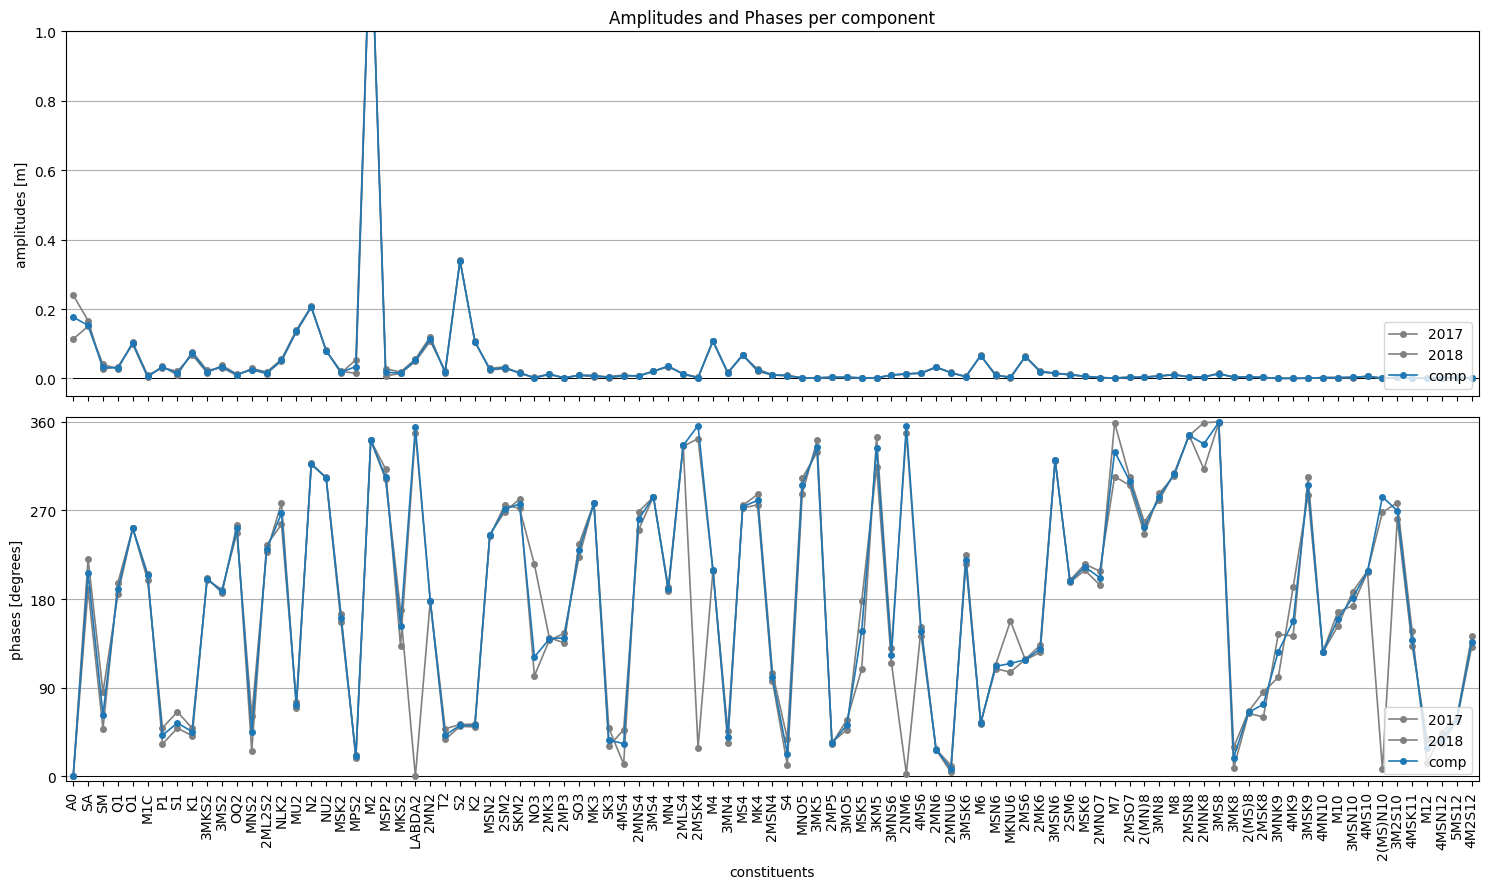

In [4]:
#tidal analysis and plotting of results 
comp_frommeas, comp_allyears = hatyan.get_components_from_ts(ts=ts_meas, const_list=const_list, nodalfactors=True, return_allperiods=True, fu_alltimes=True, analysis_perperiod='Y')
fig,(ax1,ax2) = hatyan.plot_components(comp=comp_frommeas, comp_allyears=comp_allyears)
#fig.savefig('components.png')


PREDICTION initializing
source               = schureman
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
CS_comps             = None
analysis_perperiod   = False
return_allperiods    = False
return_prediction    = False
xTxmat_condition_max = 12

components used      = 95
tstart               = 2017-01-01 00:00:00
tstop                = 2018-12-31 00:00:00
timestep             = <10 * Minutes>
freq is calculated at mid of period: 2017-12-31 12:00:00
v0 is calculated for start of period: 2017-01-01 00:00:00
nodal factors (f and u) are calculated for all timesteps
PREDICTION started
PREDICTION finished


(-0.5, 0.5)

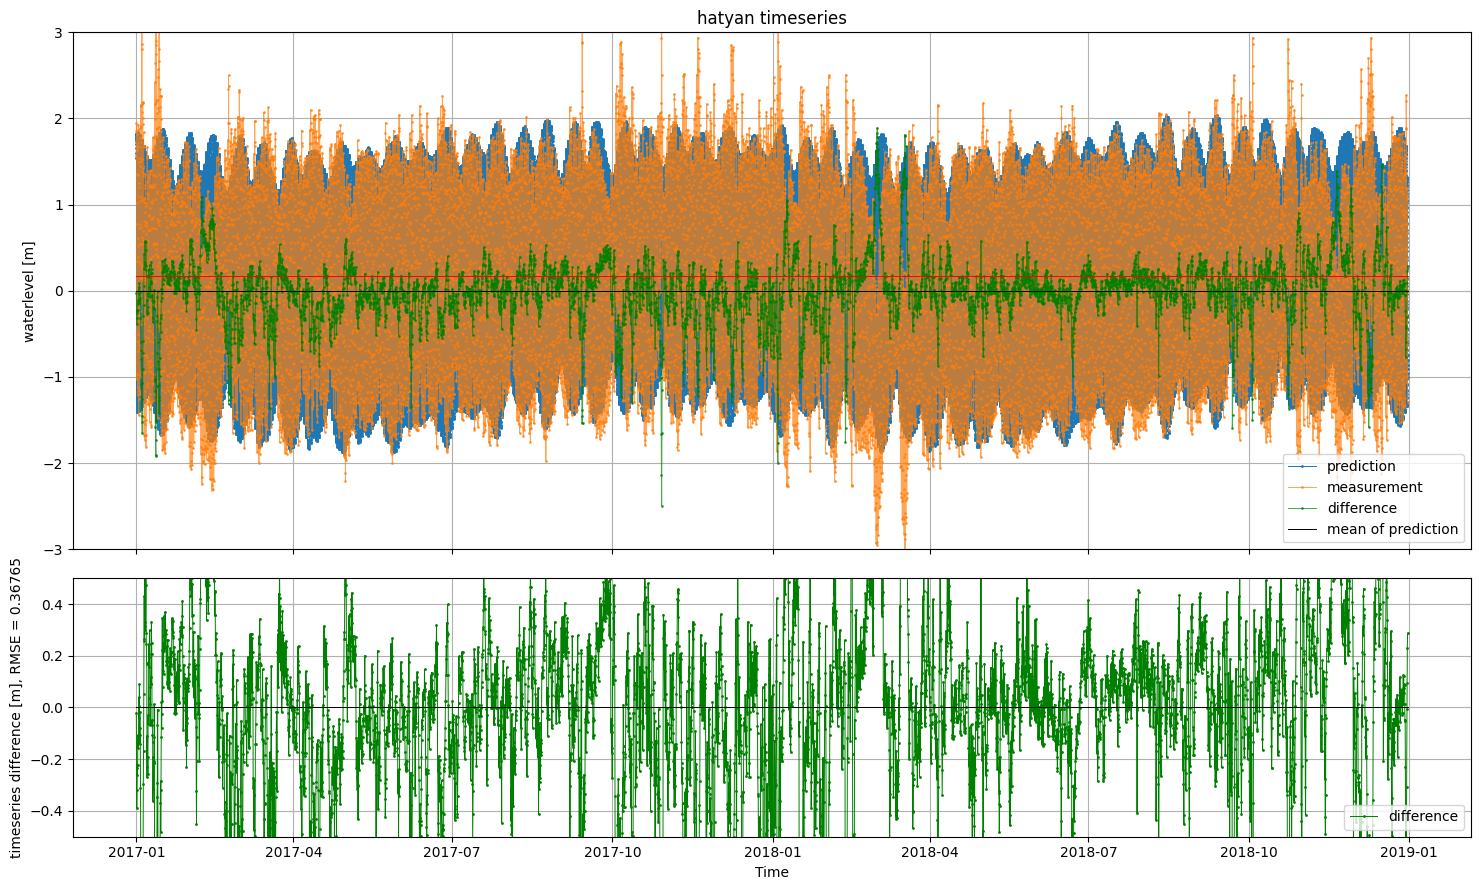

In [5]:
#tidal prediction and plotting of results
ts_prediction = hatyan.prediction(comp=comp_frommeas, nodalfactors=True, fu_alltimes=True, times_ext=times_ext, timestep_min=timestep_min)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas)
ax1.legend(['prediction','measurement','difference','mean of prediction'])
ax2.set_ylim(-0.5,0.5)
#fig.savefig('prediction.png')


Calculating comparison statistics for extremes
HWLWno is not present in ts_ext or ts_ext_validation, trying to automatically derive it without M2phasediff argument (this might fail)
ANALYSIS initializing
source               = schureman
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
CS_comps             = None
analysis_perperiod   = False
return_allperiods    = False
return_prediction    = False
xTxmat_condition_max = 250

#timesteps           = 2815
tstart               = 2017-01-01 08:30:00
tstop                = 2018-12-30 12:40:00
timestep             = None
components analyzed  = 1
percentage_nan in values_meas_sel: 0.00%
freq is calculated at mid of period: 2017-12-31 10:10:00
v0 is calculated for start of period: 2017-01-01 08:30:00
nodal factors (f and u) are calculated for all timesteps
folding frequencies over Nyquist frequency, which is half of the dominant timestep (5.666666666666667 hour), there are 14 unique timesteps)
calculating xTx

(-1.0, 1.0)

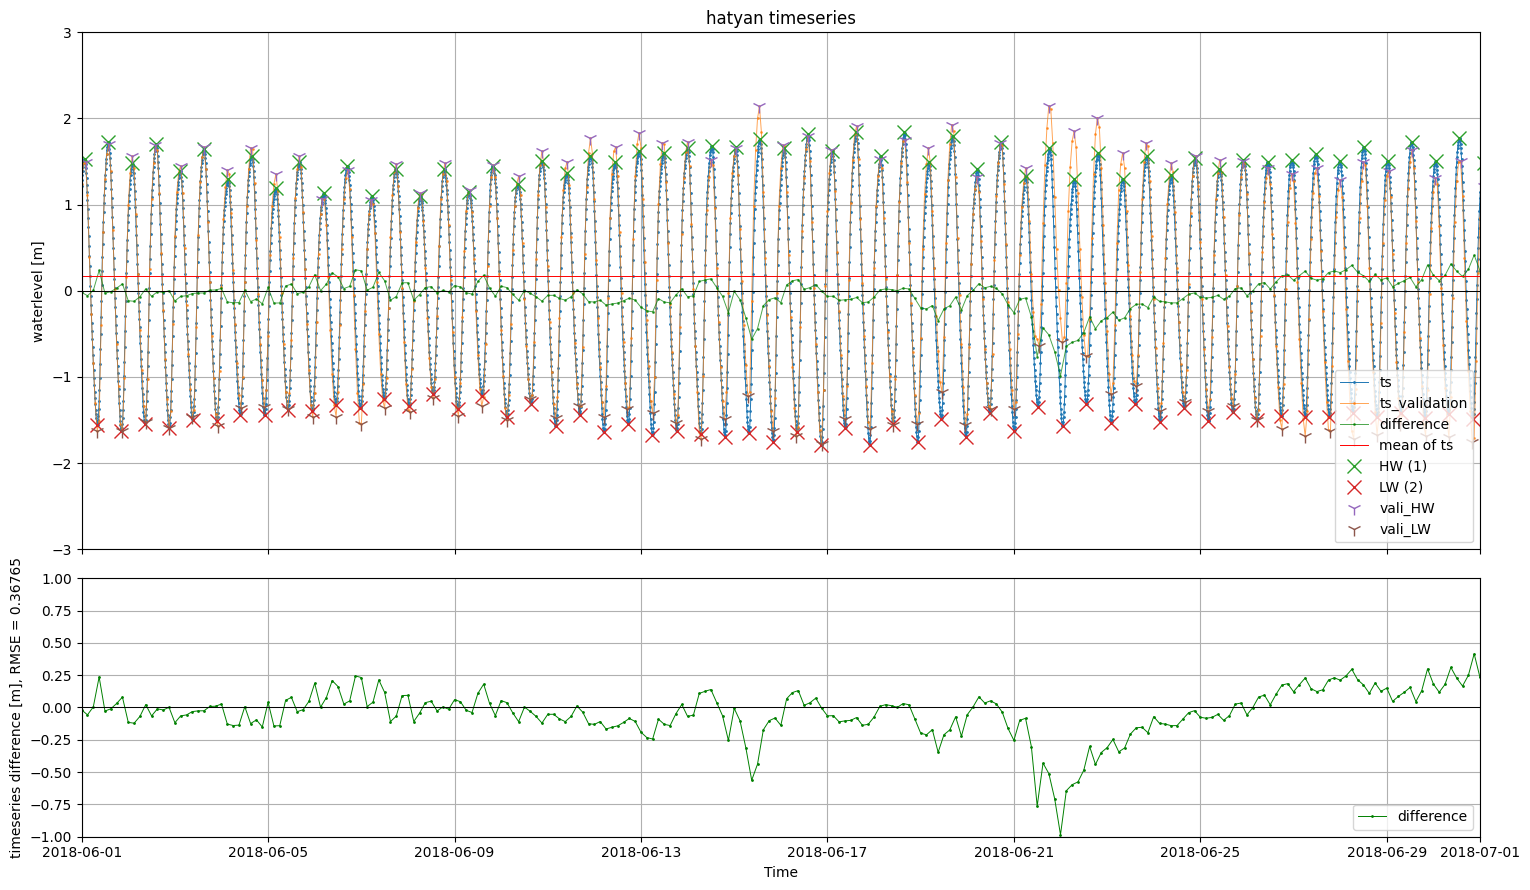

In [6]:
#calculation of HWLW and plotting of results
ts_ext_meas = hatyan.calc_HWLW(ts=ts_meas)
ts_ext_prediction = hatyan.calc_HWLW(ts=ts_prediction)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas, ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
ax1.set_xlim([dt.datetime(2018,6,1),dt.datetime(2018,7,1)])
ax2.set_ylim(-1,1)
#fig.savefig('prediction_HWLW.png')


Calculating comparison statistics for extremes
HWLWno is not present in ts_ext or ts_ext_validation, trying to automatically derive it without M2phasediff argument (this might fail)
ANALYSIS initializing
source               = schureman
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
CS_comps             = None
analysis_perperiod   = False
return_allperiods    = False
return_prediction    = False
xTxmat_condition_max = 250

#timesteps           = 2815
tstart               = 2017-01-01 08:30:00
tstop                = 2018-12-30 12:40:00
timestep             = None
components analyzed  = 1
percentage_nan in values_meas_sel: 0.00%
freq is calculated at mid of period: 2017-12-31 10:10:00
v0 is calculated for start of period: 2017-01-01 08:30:00
nodal factors (f and u) are calculated for all timesteps
folding frequencies over Nyquist frequency, which is half of the dominant timestep (5.666666666666667 hour), there are 14 unique timesteps)
calculating xTx

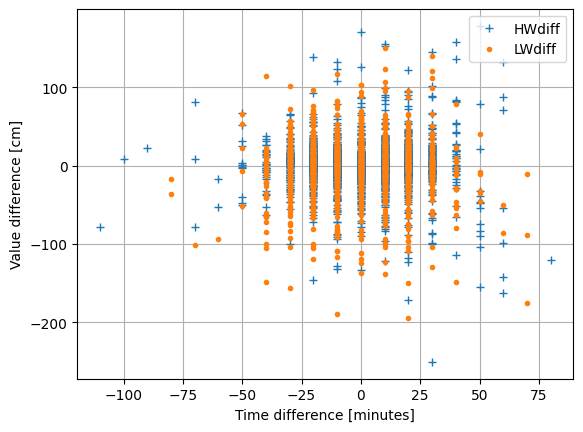

In [7]:
fig, ax = hatyan.plot_HWLW_validatestats(ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
#fig.savefig('prediction_HWLW_validatestats.png')
#hatyan.write_tsnetcdf(ts=ts_prediction, ts_ext=ts_ext_prediction, station='Cuxhaven', vertref='MSL', filename='prediction.nc')
